# Testing Stock Fetcher 

## Imports 

In [1]:
# Reload Custom Modules 
import importlib
import src.beta_vae
import src.data_fetching 
import src.portfolio
importlib.reload(src.beta_vae)
importlib.reload(src.data_fetching)
importlib.reload(src.portfolio)

<module 'src.portfolio' from 'c:\\Users\\jairp\\OneDrive\\Desktop_remote\\HEC Montreal\\4. Fall 2024\\Deep Learning II\\Project\\StockDiversifier\\src\\portfolio.py'>

In [2]:
# General 
import os 
import json 
import random 
from tqdm.notebook import tqdm

# Data Science
import optuna 
import numpy as np 
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# PyTorch
import torch

# Custom Classes 
from src.beta_vae import Encoder
from src.beta_vae import Decoder
from src.beta_vae import BetaVAE
from src.portfolio import Portfolio

# Custom Functions
from src.beta_vae import create_data_loaders
from src.beta_vae import create_single_data_loader
from src.beta_vae import objective
from src.beta_vae import train_beta_vae
from src.beta_vae import get_embeddings
from src.beta_vae import generate_embeddings_dict
from src.portfolio import fetch_and_calculate_returns
from src.portfolio import diversify_betavae_portfolio
from src.data_fetching import scrape_sp500_wikipedia
from src.data_fetching import fetch_stock_data
from src.data_fetching import prepare_data_for_vae

In [3]:
custom_tickers = [
    'PLTR',  # Palantir Technologies Inc. (Technology)
    'COIN',  # Coinbase Global, Inc. (Financials)
    'WDAY',  # Workday, Inc. (Technology)
    'TTD',   # The Trade Desk, Inc. (Technology)
    'APO',   # Apollo Global Management, Inc. (Financials)
    'MELI',  # MercadoLibre, Inc. (Consumer Discretionary)
    'NVO',   # Novo Nordisk A/S (Healthcare)
    'ICON',  # Icon PLC (Healthcare)
    'TSM',   # Taiwan Semiconductor Manufacturing Company Limited (Technology)
    'SKX',   # Skechers U.S.A., Inc. (Consumer Discretionary)
    'BAYRY', # Bayer AG (Healthcare)
    'DISCK', # Discovery, Inc. (Communication Services)
    'FNV',   # Franco-Nevada Corporation (Materials)
    'SHOP',  # Shopify Inc. (Technology)
    'SQ',    # Square, Inc. (Technology)
    'UBER',  # Uber Technologies, Inc. (Industrials)
    'ZM',    # Zoom Video Communications, Inc. (Technology)
    'TWLO',  # Twilio Inc. (Technology)
    'MRNA',  # Moderna, Inc. (Healthcare)
    'WDAY',  # Workday, Inc. (Technology)
    'DOCU',  # DocuSign, Inc. (Technology)
    'VEEV',  # Veeva Systems Inc. (Healthcare)
    'LULU',  # Lululemon Athletica Inc. (Consumer Discretionary)
    'ROKU',  # Roku, Inc. (Communication Services)
    'CRWD',  # CrowdStrike Holdings, Inc. (Technology)
    'SNOW',  # Snowflake Inc. (Technology)
    'NET',   # Cloudflare, Inc. (Technology)
    'PINS',  # Pinterest, Inc. (Communication Services)
    'ETSY',  # Etsy, Inc. (Consumer Discretionary)
    'SPOT',   # Spotify Technology S.A. (Communication Services)
    "AAPL", # Apple Inc. (Technology)
]

## Fetching the data 

In [4]:
# Convert ndarray values to lists for JSON serialization
def serialize_ndarray(data_dict):
    return {key: (value.tolist() if isinstance(value, np.ndarray) else value) for key, value in data_dict.items()}

# Convert lists back to ndarrays if needed
def deserialize_ndarray(data_dict):
    return {key: (np.array(value) if isinstance(value, list) else value) for key, value in data_dict.items()}

In [ ]:
# Scrape S&P 500 companies names, tikers and industris from Wikipedia
sp500_df = scrape_sp500_wikipedia()  

# extract the tickers from the dataframe
sp500_tickers = sp500_df["Symbol"].tolist()

# check for tikers with anomalies 
anomalies = [ticker for ticker in sp500_tickers if not ticker.isalnum()]
print(anomalies)

# check if apple is in the tickers
print("AAPL" in sp500_tickers)

# show the first couple of columns 
print(sp500_df.head())

['BRK.B', 'BF.B']
True
  Symbol             Security             GICS Sector
0    MMM                   3M             Industrials
1    AOS          A. O. Smith             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV               AbbVie             Health Care
4    ACN            Accenture  Information Technology


In [7]:
REFETCH = True 
LOAD_RETURNS = False 

############################################################################################
### Step 1: Scrape SP500 

# Scrape S&P 500 companies names, tikers and industris from Wikipedia
sp500_df = scrape_sp500_wikipedia()  

############################################################################################
## Step 2: Fetch Stock Data Features 

if REFETCH:
    # Fetch data for all sp500 + custom tickers
    stock_data, sector_mapping, industry_mapping = fetch_stock_data(sp500_df, custom_tickers, 
                                                                    period = "1y", interval = "1wk",
                                                                    savepath="data_raw/stock_data.csv") # Fetch data
else: 
    # read data from file
    stock_data = pd.read_csv("data_raw/stock_data.csv", index_col=0).reset_index()

Fetching stock data...:  31%|███       | 164/527 [03:51<08:24,  1.39s/it]ICON: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
ICON: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
Fetching stock data...:  32%|███▏      | 169/527 [03:57<07:50,  1.31s/it]$DISCK: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$DISCK: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
Fetching stock data...:  67%|██████▋   | 353/527 [08:19<04:06,  1.42s/it]AMTM: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
AMTM: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
Fetching stock data...:  93%|█████████▎| 491/527 [11:27<00:48,  1.35s/it]SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SW: Period '1y' is invalid,

Completed fetching stock data in 734.84 seconds.
saving data to data_raw/stock_data.csv


In [8]:
############################################################################################
## Step 3: Fetch Returns for all tickers

if LOAD_RETURNS:
    # Load the returns from the file
    with open("data_raw/all_returns.json", "r") as f:
        all_returns = json.load(f)

    # Deserialize loaded data
    all_returns = deserialize_ndarray(all_returns)

    # Show the first few tickers and their returns
    print("First few tickers and their returns:")
    for ticker, returns in list(all_returns.items())[:5]:
        print(f"{ticker}: {returns[:5]}...")  # Print first 5 returns for each ticker

else: 
    # Fetch and calculate returns for the all tickers in the S&P 500 and additional tickers
    all_tickers = stock_data["Ticker"].values.tolist()  # All S&P 500 tickers
    print(f"number of tickers: {len(all_tickers)}")

    # Fetch and calculate returns for all tickers
    all_returns = fetch_and_calculate_returns(all_tickers, period="1y", interval="1wk", price_column="Close")

    # Find the mode of the lengths of the returns among all tickers
    return_lengths = [len(returns) for returns in all_returns.values()]
    return_length_mode = max(set(return_lengths), key=return_lengths.count)

    # Ensure to keep only the returns with the mode length and report the discarded tickers 
    discarded_tickers = [ticker for ticker, returns in all_returns.items() if len(returns) != return_length_mode]
    all_returns = {ticker: returns for ticker, returns in all_returns.items() if len(returns) == return_length_mode}
    print(f"Discarded tickers with inconsistent return lengths: {discarded_tickers}")

    # Remove from stock_data the tickers with inconsistent return lengths
    stock_data = stock_data[stock_data["Ticker"].isin(all_returns.keys())].reset_index().drop(columns=["index"])

    print("Total number of tickers with consistent return lengths:", len(all_returns))
    print("stock_date shape:", stock_data.shape)

    # Save the dictionary with the returns to a file using json 
    with open("data_raw/all_returns.json", "w") as f:
        print(f"Saving returns to {f.name}")
        json.dump(serialize_ndarray(all_returns), f, indent=4)

############################################################################################
## Step 4: Prepare Data for VAE	

# Prepare data for VAE
stock_data_vae = prepare_data_for_vae(stock_data) 

number of tickers: 523


Fetching Data: 100%|██████████| 523/523 [09:59<00:00,  1.15s/ticker]

Discarded tickers with inconsistent return lengths: ['SOLV', 'GEV']
Total number of tickers with consistent return lengths: 521
stock_date shape: (521, 18)
Saving returns to data_raw/all_returns.json


In [9]:
# Show one example return series
print("Returns for AAPL:")
print(all_returns["AAPL"])

Returns for AAPL:
[ 0.02337379  0.00950388 -0.02009418 -0.00552689 -0.05895183  0.02616181
  0.03033562  0.00448944 -0.03414403  0.01614209 -0.03339895  0.00115197
 -0.01566941 -0.04970521  0.01107025 -0.00196965 -0.00464362 -0.01108006
  0.04110163 -0.06542058  0.02606062  0.08316588 -0.00179947  0.03866449
  0.00057929  0.01194867  0.02413527  0.07923203 -0.02353049  0.01508496
  0.0746368   0.01855617 -0.02702351 -0.02830899  0.00871714 -0.01646491
  0.04536618  0.00465631  0.00952219 -0.0357205   0.00760797  0.02561793
 -0.00179665 -0.00434609  0.00330688  0.03274001 -0.01527655 -0.03673136
  0.01816883 -0.00754524  0.02164442  0.02257799]


In [10]:
stock_data.head()

,Ticker,Company Name,Market Cap,Sector,Industry,Open Price,Close Price,High Price,Low Price,Last Close,52 Week High,52 Week Low,Last Month Volatility,52 Week Volatility,Yearly Dividend Rate,Last Year Return Rate,Sector_encoded,Industry_encoded
0,IEX,IDEX Corporation,1.756932e+10,Industrials,Specialty Industrial Machinery,213.503752,213.917208,243.958732,188.882687,232.020004,243.958747,188.882686,0.206711,0.205995,2.76,0.183390,0,0
1,XOM,Exxon Mobil Corporation,5.184888e+11,Energy,Oil & Gas Integrated,110.321420,110.561585,125.310308,92.610904,117.970001,125.310309,92.610907,0.202498,0.194221,3.96,0.173472,1,1
2,EXPE,"Expedia Group, Inc.",2.390829e+10,Consumer Discretionary,Travel Services,138.769622,139.722641,190.399994,107.250000,186.279999,190.399994,107.250000,0.369555,0.374960,0.00,0.370714,2,2
3,PLD,"Prologis, Inc.",1.075937e+11,Real Estate,REIT - Industrial,119.825885,120.031163,133.491226,99.505196,116.169998,133.601161,99.505194,0.259944,0.252468,3.84,0.069777,3,3
4,SYK,Stryker Corporation,1.485637e+11,Health Care,Medical Devices,339.059300,340.545589,398.200012,283.076583,389.709991,398.200012,283.076583,0.190887,0.186960,3.20,0.338433,4,4


In [11]:
# Display the data 
print(stock_data_vae.head())

     Market Cap  Open Price  Close Price  High Price   Low Price  Last Close  \
0  1.756932e+10  213.503752   213.917208  243.958732  188.882687  232.020004   
1  5.184888e+11  110.321420   110.561585  125.310308   92.610904  117.970001   
2  2.390829e+10  138.769622   139.722641  190.399994  107.250000  186.279999   
3  1.075937e+11  119.825885   120.031163  133.491226   99.505196  116.169998   
4  1.485637e+11  339.059300   340.545589  398.200012  283.076583  389.709991   

   52 Week High  52 Week Low  Last Month Volatility  52 Week Volatility  ...  \
0    243.958747   188.882686               0.206711            0.205995  ...   
1    125.310309    92.610907               0.202498            0.194221  ...   
2    190.399994   107.250000               0.369555            0.374960  ...   
3    133.601161    99.505194               0.259944            0.252468  ...   
4    398.200012   283.076583               0.190887            0.186960  ...   

   Industry_Tools & Accessories  Indus

In [12]:
# Print number of columns for stock_data 
print(len(stock_data.columns))

# Print number of columns in total 
print(len(stock_data_vae.columns))

# Print total number of rows 
print(len(stock_data_vae))

# Print the data types of the columns
print(stock_data_vae.dtypes)

18
145
521
Market Cap                                 float64
Open Price                                 float64
Close Price                                float64
High Price                                 float64
Low Price                                  float64
                                            ...   
Industry_Utilities - Regulated Electric    float64
Industry_Utilities - Regulated Gas         float64
Industry_Utilities - Regulated Water       float64
Industry_Utilities - Renewable             float64
Industry_Waste Management                  float64
Length: 145, dtype: object


In [13]:
print(stock_data_vae.columns)

Index(['Market Cap', 'Open Price', 'Close Price', 'High Price', 'Low Price',
       'Last Close', '52 Week High', '52 Week Low', 'Last Month Volatility',
       '52 Week Volatility',
       ...
       'Industry_Tools & Accessories', 'Industry_Travel Services',
       'Industry_Trucking', 'Industry_Utilities - Diversified',
       'Industry_Utilities - Independent Power Producers',
       'Industry_Utilities - Regulated Electric',
       'Industry_Utilities - Regulated Gas',
       'Industry_Utilities - Regulated Water',
       'Industry_Utilities - Renewable', 'Industry_Waste Management'],
      dtype='object', length=145)


### Check for any NA's

In [14]:
# Check if any columns have nas
print(stock_data_vae.isna().sum().sum())

# Produce a list of columns with nas, and the amount for each 
print(stock_data_vae.columns[stock_data_vae.isna().any()].tolist())

# Calculate the proportion of nas in the stock_data_vae dataframe for each column with nas 
# only for the columns with nas
nas_proportion = stock_data_vae.isna().mean()
print(nas_proportion[stock_data_vae.columns[stock_data_vae.isna().any()].tolist()])

0
[]
Series([], dtype: float64)


## Fitting the $\beta$-VAE

### Data Preparation

In [15]:
# Normalize the stock data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(stock_data_vae)

# Convert the normalized data to PyTorch tensors
tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(tensor_data)

# Check the DataLoader output
next(iter(train_loader))[0].shape  # Shape of one batch of data

torch.Size([64, 145])

### Hyperparameter Tunning

In [16]:
# Define the file path for storing the best parameters
best_params_file = "config/best_params.json"

REWRITE = True 
if REWRITE:
    # Delete previous best_params file
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

# Check if the best_params file exists
if os.path.exists(best_params_file):
    # Load the best parameters from the file
    with open(best_params_file, "r") as f:
        best_params = json.load(f)
    print("Loaded best parameters from file:", best_params)
    
else:
    # Delete previous best_params file if exists
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

    # File doesn't exist, run the Optuna study
    print("Best parameters file not found. Running Optuna study...")
    
    # Assuming `normalized_data` is the prepared dataset
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, normalized_data, verbose=False), n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params
    print("Best hyperparameters found:", best_params)

    # Save the best parameters to a JSON file
    os.makedirs(os.path.dirname(best_params_file), exist_ok=True)  # Create directory if it doesn't exist
    with open(best_params_file, "w") as f:
        json.dump(best_params, f, indent=4)
    print(f"Best parameters saved to {best_params_file}")

[I 2024-11-26 23:00:37,323] A new study created in memory with name: no-name-47c276ee-a9a7-49db-8aeb-9b27baacf129


Best parameters file not found. Running Optuna study...


[I 2024-11-26 23:00:40,776] Trial 0 finished with value: 157.03168194110577 and parameters: {'latent_dim': 5, 'beta': 7.094033176994349, 'learning_rate': 0.00013219270010243777, 'batch_size': 128}. Best is trial 0 with value: 157.03168194110577.
[I 2024-11-26 23:00:41,068] Trial 1 finished with value: 133.45130870106456 and parameters: {'latent_dim': 10, 'beta': 8.121893791768645, 'learning_rate': 0.0018797181571665455, 'batch_size': 128}. Best is trial 1 with value: 133.45130870106456.
[I 2024-11-26 23:00:41,343] Trial 2 finished with value: 142.20008799793956 and parameters: {'latent_dim': 5, 'beta': 8.382124455349121, 'learning_rate': 0.0002441792917670414, 'batch_size': 128}. Best is trial 1 with value: 133.45130870106456.
[I 2024-11-26 23:00:42,049] Trial 3 finished with value: 133.44293883606628 and parameters: {'latent_dim': 10, 'beta': 4.660668936454833, 'learning_rate': 0.0018213877562869567, 'batch_size': 32}. Best is trial 3 with value: 133.44293883606628.
[I 2024-11-26 23:0

Best hyperparameters found: {'latent_dim': 5, 'beta': 5.050561431823933, 'learning_rate': 0.000805687447285926, 'batch_size': 32}
Best parameters saved to config/best_params.json


### Model Training

In [17]:

# File path for the saved model
model_path = "models/beta_vae_with_metadata.pth"

RETRAIN = True
if RETRAIN:
    # Delete previous model file
    if os.path.exists(model_path):
        os.remove(model_path)

# Check if the model file exists
if os.path.exists(model_path):
    print(f"Model found at {model_path}. Loading the model...")

    # Load model state and metadata
    model_metadata = torch.load(model_path)

    # Recreate the model using the saved metadata
    beta_vae = BetaVAE(
        input_dim=model_metadata["input_dim"],
        latent_dim=model_metadata["latent_dim"],
        beta=model_metadata["beta"]
    )
    beta_vae.load_state_dict(model_metadata["model_state"])
    beta_vae.eval()  # Set the model to evaluation mode
    print("Model loaded successfully.")
else:
    print(f"Model not found at {model_path}. Training a new model...")

    # Assuming you use the best hyperparameters from Optuna
    latent_dim = best_params['latent_dim']
    beta = best_params['beta']
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']
    input_dim = stock_data_vae.shape[1]

    # Recreate DataLoaders with the best batch size
    train_loader, val_loader, test_loader = create_data_loaders(tensor_data, batch_size=batch_size)

    # Initialize and train the model
    beta_vae = BetaVAE(input_dim=input_dim, latent_dim=latent_dim, beta=beta)
    train_beta_vae(beta_vae, train_loader, val_loader, num_epochs=50, learning_rate=learning_rate)

    # Save the trained model with metadata
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Ensure the directory exists
    model_metadata = {
        "model_state": beta_vae.state_dict(),
        "input_dim": input_dim,
        "latent_dim": latent_dim,
        "beta": beta
    }
    torch.save(model_metadata, model_path)
    print(f"Model trained and saved to {model_path}.")

Model not found at models/beta_vae_with_metadata.pth. Training a new model...
Epoch [1/50], Training Loss: 155.2150
Epoch [1/50], Validation Loss: 132.9233
Epoch [2/50], Training Loss: 135.7170
Epoch [2/50], Validation Loss: 127.9927
Epoch [3/50], Training Loss: 133.5458
Epoch [3/50], Validation Loss: 127.7345
Epoch [4/50], Training Loss: 133.4564
Epoch [4/50], Validation Loss: 127.6884
Epoch [5/50], Training Loss: 133.4421
Epoch [5/50], Validation Loss: 127.6844
Epoch [6/50], Training Loss: 133.4454
Epoch [6/50], Validation Loss: 127.6857
Epoch [7/50], Training Loss: 133.4403
Epoch [7/50], Validation Loss: 127.6998
Epoch [8/50], Training Loss: 133.4376
Epoch [8/50], Validation Loss: 127.6765
Epoch [9/50], Training Loss: 133.4367
Epoch [9/50], Validation Loss: 127.7160
Epoch [10/50], Training Loss: 133.4307
Epoch [10/50], Validation Loss: 127.7129
Epoch [11/50], Training Loss: 133.4220
Epoch [11/50], Validation Loss: 127.7308
Epoch [12/50], Training Loss: 133.4342
Epoch [12/50], Valida

### Extract Embeddings for Train/Val/Test Data 

In [18]:
# Extract embeddings for the training data
train_embeddings = get_embeddings(beta_vae, train_loader)

# Optionally, extract embeddings for validation and test data
val_embeddings = get_embeddings(beta_vae, val_loader)
test_embeddings = get_embeddings(beta_vae, test_loader)

print("Train Embeddings Shape:", train_embeddings.shape)  # Should be (num_samples, latent_dim)
print("Val Embeddings Shape:", val_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)
print("Total number of embeddings:", train_embeddings.shape[0] + val_embeddings.shape[0] + test_embeddings.shape[0])

Train Embeddings Shape: torch.Size([364, 5])
Val Embeddings Shape: torch.Size([78, 5])
Test Embeddings Shape: torch.Size([79, 5])
Total number of embeddings: 521


### Extract Embeddings from the Stock Data 

In [19]:
# Generate embeddings for the stock data
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Display the embeddings for the first stock
print(f"Embeddings for the first stock ({stock_data['Ticker'].iloc[0]}):")
print(stock_embeddings[stock_data["Ticker"].iloc[0]])

Embeddings for the first stock (IEX):
[-0.2896623   0.0427687   0.25220585 -0.04072824  1.2952378 ]


### Building the Recommendation Function 

#### Building the Portfolio

Portfolio Summary:
Tickers: ['SLB', 'IBM', 'ON', 'YUM', 'DELL', 'L', 'ALLE', 'MCK', 'GDDY', 'CSCO', 'AME', 'BK', 'GPC', 'VZ', 'MMM', 'LRCX', 'LVS', 'ZBH', 'BMY', 'KKR']
Weights: {'SLB': 0.05, 'IBM': 0.05, 'ON': 0.05, 'YUM': 0.05, 'DELL': 0.05, 'L': 0.05, 'ALLE': 0.05, 'MCK': 0.05, 'GDDY': 0.05, 'CSCO': 0.05, 'AME': 0.05, 'BK': 0.05, 'GPC': 0.05, 'VZ': 0.05, 'MMM': 0.05, 'LRCX': 0.05, 'LVS': 0.05, 'ZBH': 0.05, 'BMY': 0.05, 'KKR': 0.05}
Portfolio Expected Return: 0.005840315006580565
Portfolio Volatility: 0.018978614912709517
Portfolio Diversification Ratio: 2.0522258295162406
Portfolio Sharpe Ratio: 0.3077313615057044


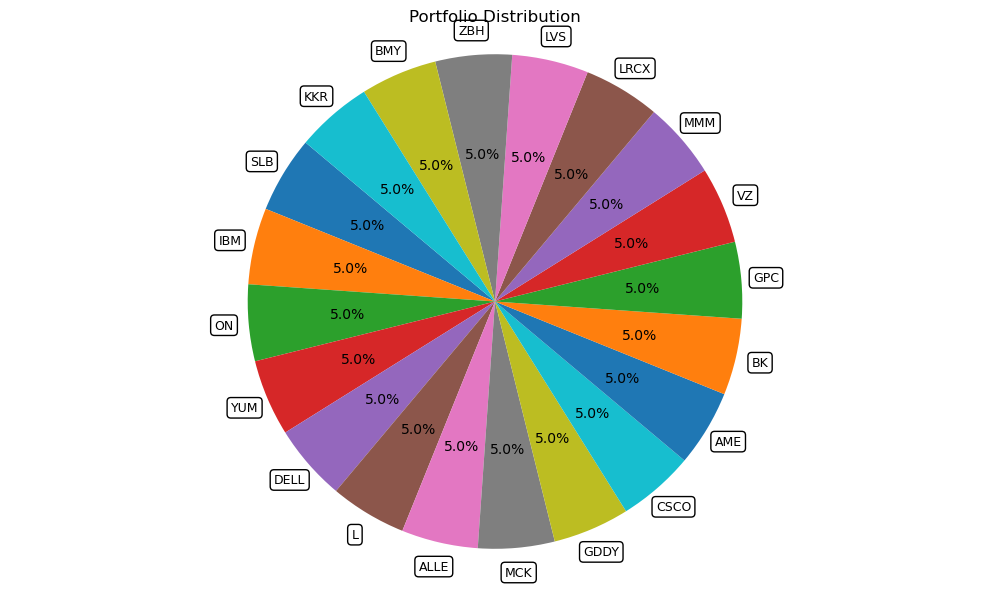

In [21]:
# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 20, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Obtain a summary of the portfolio 
random_portfolio.summarize_portfolio()

# Visualize portfolio distribution 
random_portfolio.visualize_portfolio_distribution()


#### Optimizing the Portfolio 


--- Portfolio Summary After Optimization ---
Portfolio Summary:
Tickers: ['SLB', 'IBM', 'ON', 'YUM', 'DELL', 'L', 'ALLE', 'MCK', 'GDDY', 'CSCO', 'AME', 'BK', 'GPC', 'VZ', 'MMM', 'LRCX', 'LVS', 'ZBH', 'BMY', 'KKR']
Weights: {'SLB': 1.4638575566298806e-16, 'IBM': 0.0, 'ON': 0.03693219623324333, 'YUM': 0.07272870534500007, 'DELL': 0.016323530030092067, 'L': 0.0, 'ALLE': 7.841297224484109e-17, 'MCK': 0.08080394067395481, 'GDDY': 0.08044272749458524, 'CSCO': 1.0862230839364133e-17, 'AME': 0.02292186353405232, 'BK': 1.4560549810189684e-16, 'GPC': 3.9796361505035176e-16, 'VZ': 0.2859299651794856, 'MMM': 0.13060694944868342, 'LRCX': 0.09325952659658389, 'LVS': 0.09661330305258212, 'ZBH': 0.0, 'BMY': 0.083437292411737, 'KKR': 0.0}
Portfolio Expected Return: 0.005730631527333146
Portfolio Volatility: 0.016374596995294574
Portfolio Diversification Ratio: 2.448171367588188
Portfolio Sharpe Ratio: 0.34997084380030286


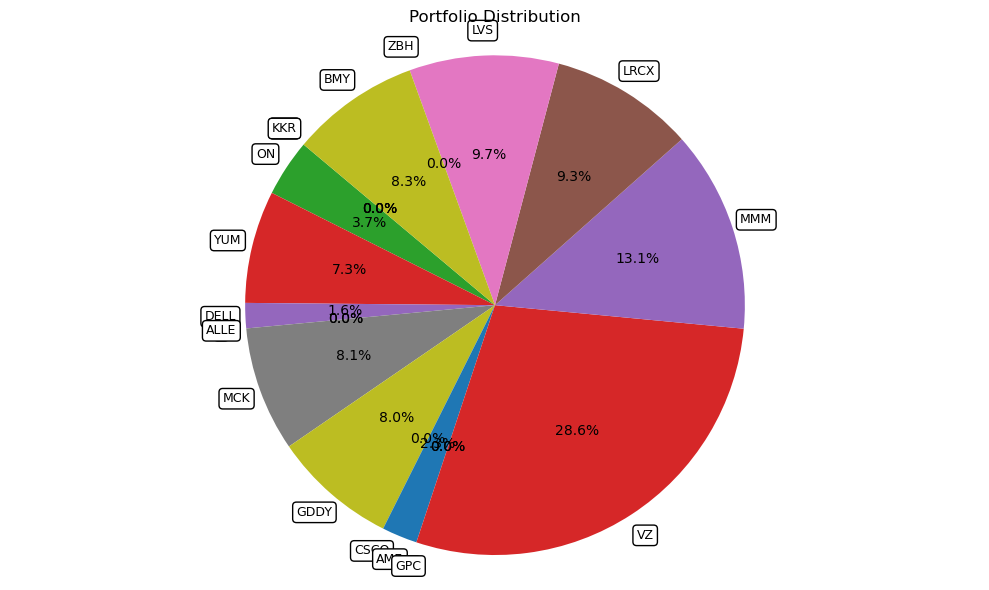

In [22]:
# Optimize portfolio weights 
random_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the portfolio after optimization
print("\n--- Portfolio Summary After Optimization ---")
random_portfolio.summarize_portfolio()

# Visualize the portfolio distribution after optimization
random_portfolio.visualize_portfolio_distribution()

#### Extracting Portfolio Embeddings

In [23]:
# Define Optim method for both portfolios 
optim_method = "max_div"

# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 15, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Optimize portfolio weights 
random_portfolio.optimize_weights(method=optim_method, update_weights=True)

# Generate embeddings for the stock data (full universe of data)
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Extract embeddings from Portfolio  
random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
                               if ticker in stock_embeddings.keys()}

# Check that number of extracted embeddings == number of portfolio tickers
assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)

# Apply the diversify function to the random portfolio
updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
    portfolio = random_portfolio,
    portfolio_embeddings = random_portfolio_embeddings,
    all_returns = all_returns,
    all_stock_embeddings = stock_embeddings,
    num_iter=200, # number of iterations for the optimization algorithm
    top_N=5, # num top most dissimilar assets to consider for swapping
    optim_algorithm=optim_method,
    distance_type="euclidean"
)

# Print the final diversification ratio and the swap log
print("\nFinal Diversification Ratio:", updated_portfolio.diversification_ratio)
print("Diversification History:", diversification_history)
print("Swap Log (Removed -> Added):", swap_log)


Initial Diversification Ratio: 2.0947227178468686


Diversification Iterations:   5%|▌         | 10/200 [00:00<00:01, 99.75it/s]

Accepted Swap: MGM -> ACGL
New Diversification Ratio: 2.272796888173833
Accepted Swap: VLTO -> CHD
New Diversification Ratio: 2.3879954490166555
Accepted Swap: OKE -> AFL
New Diversification Ratio: 2.4275831900560494
Accepted Swap: AFL -> TYL
New Diversification Ratio: 2.4864384131175226
Accepted Swap: DOCU -> GM
New Diversification Ratio: 2.5049906850078565
Accepted Swap: VRSK -> CME
New Diversification Ratio: 2.6219431715184878
Accepted Swap: TDG -> BKNG
New Diversification Ratio: 2.6259928865534325
Accepted Swap: CME -> LUV
New Diversification Ratio: 2.6581963412674425
Accepted Swap: FI -> EXR
New Diversification Ratio: 2.6730972923897216


Diversification Iterations:  10%|█         | 20/200 [00:00<00:02, 86.47it/s]

Accepted Swap: HPQ -> VZ
New Diversification Ratio: 2.7753044235122735


Diversification Iterations: 100%|██████████| 200/200 [00:02<00:00, 82.18it/s]


Final Diversification Ratio: 2.7753044235122735
Diversification History: [2.0947227178468686, 2.272796888173833, 2.3879954490166555, 2.4275831900560494, 2.4864384131175226, 2.5049906850078565, 2.6219431715184878, 2.6259928865534325, 2.6581963412674425, 2.6730972923897216, 2.7753044235122735]
Swap Log (Removed -> Added): {'MGM': 'ACGL', 'VLTO': 'CHD', 'OKE': 'AFL', 'AFL': 'TYL', 'DOCU': 'GM', 'VRSK': 'CME', 'TDG': 'BKNG', 'CME': 'LUV', 'FI': 'EXR', 'HPQ': 'VZ'}


In [24]:
print("\n--- Original Portfolio ---")
# Summarize the original random portfolio
random_portfolio.summarize_portfolio()

print("\n--- Updated Portfolio ---")

# Optimize the updated portfolio weights with max_div 
updated_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the updated portfolio
updated_portfolio.summarize_portfolio()


--- Original Portfolio ---
Portfolio Summary:
Tickers: ['HPQ', 'TDG', 'DOCU', 'MGM', 'FIS', 'FI', 'OKE', 'JBHT', 'VRSK', 'NCLH', 'VLTO', 'WFC', 'KR', 'ABNB', 'INTC']
Weights: {'HPQ': 1.7077956264345166e-16, 'TDG': 0.06269732483851391, 'DOCU': 0.04006927872743855, 'MGM': 0.06919528358272817, 'FIS': 0.12517313958475784, 'FI': 1.9544736586578562e-16, 'OKE': 0.06080355905382928, 'JBHT': 0.001675310440410185, 'VRSK': 0.2350160247431063, 'NCLH': 7.953656952947677e-17, 'VLTO': 0.10205144643735982, 'WFC': 1.7046568735548505e-16, 'KR': 0.18063760439627924, 'ABNB': 0.12268102819557523, 'INTC': 1.759124483609912e-15}
Portfolio Expected Return: 0.0056045382305039484
Portfolio Volatility: 0.014817159337764502
Portfolio Diversification Ratio: 2.0947227178468686
Portfolio Sharpe Ratio: 0.37824647105060544

--- Updated Portfolio ---
Portfolio Summary:
Tickers: ['FIS', 'JBHT', 'NCLH', 'WFC', 'KR', 'ABNB', 'INTC', 'ACGL', 'CHD', 'TYL', 'GM', 'BKNG', 'LUV', 'EXR', 'VZ']
Weights: {'FIS': 0.02241533131615

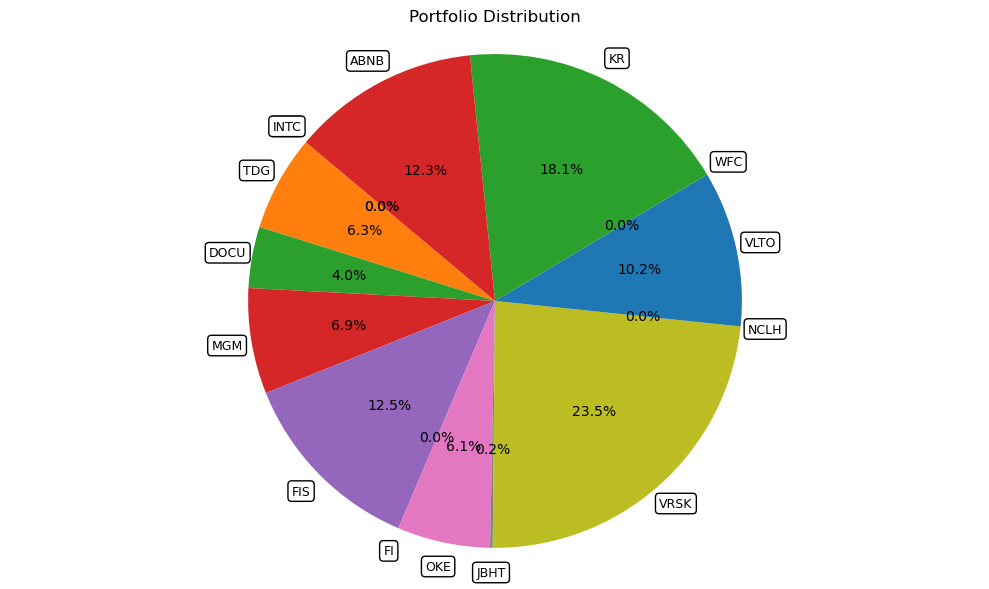

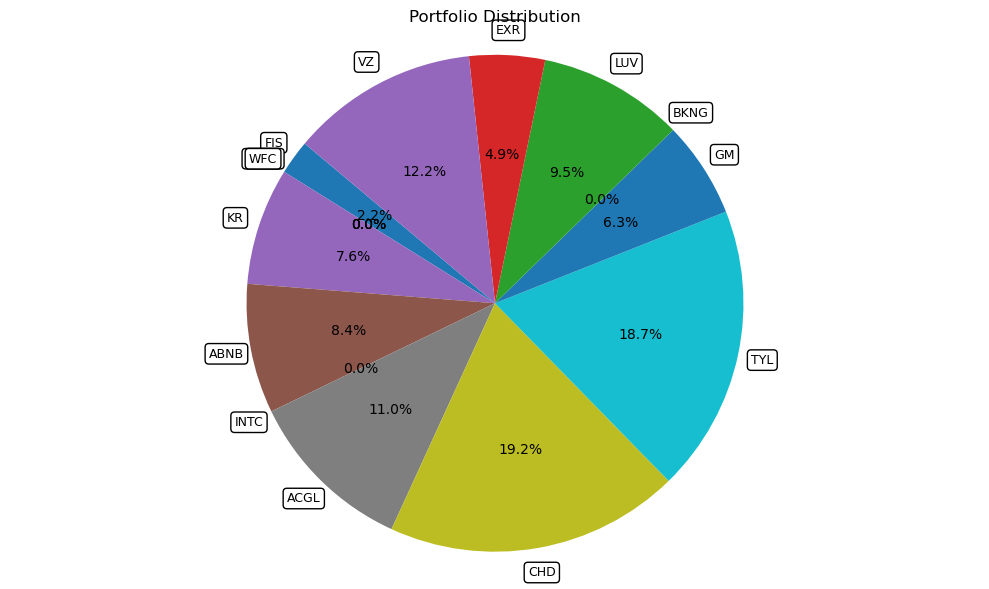

In [25]:
random_portfolio.visualize_portfolio_distribution()
updated_portfolio.visualize_portfolio_distribution()

## Implementing the Full Experiment 

In [38]:
# Initialize storage for portfolio results
portfolio_results = []
portfolio_tickers = {}

# Define number of iterations for diversification process
num_portfolios = 15
num_initial_tickers = 15
optim_method = "max_div"

for i in tqdm(range(1, num_portfolios + 1), desc="Beta-VAE Portfolio Diversification..."):
    # Step 1: Generate random portfolio
    random_tickers = np.random.choice(list(all_returns.keys()), num_initial_tickers, replace=False)
    random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}
    random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")
    
    # Optimize initial portfolio
    random_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
    # Record initial DR and SR
    initial_dr = random_portfolio.diversification_ratio
    initial_sr = random_portfolio.sharpe_ratio
    
    # Step 2: Generate embeddings
    random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
                                   if ticker in stock_embeddings.keys()}
    assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)
    
    # Step 3: Apply diversification function
    updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
        portfolio=random_portfolio,
        portfolio_embeddings=random_portfolio_embeddings,
        all_returns=all_returns,
        all_stock_embeddings=stock_embeddings,
        num_iter=200,
        top_N=5,
        optim_algorithm=optim_method,
        distance_type="euclidean", 
        verbose=False
    )
    
    # Optimize the updated portfolio after swaps
    updated_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
    # Record updated DR and SR
    final_dr = updated_portfolio.diversification_ratio
    final_sr = updated_portfolio.sharpe_ratio
    
    # Store tickers for the updated portfolio
    portfolio_tickers[f"Portfolio_{i}"] = updated_portfolio.tickers
    
    # Save results for the dataframe
    portfolio_results.append({
        "Portfolio": f"Portfolio_{i}",
        "Initial_DR": initial_dr,
        "Final_DR": final_dr,
        "DR_Improvement": round(((final_dr - initial_dr)/initial_dr) * 100, 3), # pct improvement
        "Initial_SR": initial_sr,
        "Final_SR": final_sr, 
        "SR_Improvement": round(((final_sr - initial_sr)/initial_sr) * 100, 3), # pct improvement
        "Tickers": updated_portfolio.tickers
    })

# Convert results to a DataFrame
portfolio_results_df = pd.DataFrame(portfolio_results)

# Sort by Final_DR
portfolio_results_df = portfolio_results_df.sort_values(by="DR_Improvement", ascending=False)


Beta-VAE Portfolio Diversification...:   0%|          | 0/15 [00:00<?, ?it/s]

Diversification Iterations: 100%|██████████| 200/200 [00:02<00:00, 92.22it/s]


In [41]:
# Display the table
display(portfolio_results_df)

,Portfolio,Initial_DR,Final_DR,DR_Improvement,Initial_SR,Final_SR,SR_Improvement,Tickers
10,Portfolio_11,2.290791,3.561540,55.472,0.286146,0.434153,51.724,"[TRV, CBOE, HOLX, TYL, VLO, D, LUV, CHD, ELV, ..."
3,Portfolio_4,2.126182,3.180261,49.576,0.412033,0.281374,-31.711,"[TRGP, VRSN, INTC, D, TYL, GPC, MDLZ, LUV, RVT..."
0,Portfolio_1,2.148243,3.022370,40.690,0.226900,0.409897,80.651,"[INTC, GD, PARA, FDS, NFLX, DLTR, MCHP, CHD, T..."
12,Portfolio_13,2.507011,3.303468,31.769,0.228684,0.295116,29.050,"[LRCX, PAYC, MU, TAP, AEE, HES, CME, EXR, CB, ..."
8,Portfolio_9,2.449682,3.163624,29.144,0.410507,0.519921,26.653,"[WMB, AAPL, HSIC, NUE, CAH, SO, CME, BSX, TYL,..."
5,Portfolio_6,2.383210,2.976422,24.891,0.269684,0.316667,17.422,"[SLB, DD, CRL, AME, AWK, DHR, STZ, RMD, EQR, Z..."
4,Portfolio_5,2.495005,3.000056,20.243,0.344737,0.302462,-12.263,"[DHR, NI, K, ON, CBOE, XEL, MS, STX, CRL, LUV,..."
6,Portfolio_7,3.074669,3.696648,20.229,0.429226,0.494784,15.274,"[PM, BG, NTAP, A, WRB, EMR, NXPI, ABNB, BSX, C..."
9,Portfolio_10,2.688159,3.204855,19.221,0.183454,0.349396,90.454,"[T, LULU, A, SLB, DGX, LKQ, ADBE, D, BSX, FICO..."
11,Portfolio_12,2.401751,2.763344,15.055,0.166525,0.262346,57.542,"[ATO, MAR, CCI, DFS, TJX, OXY, EQT, NOW, BLK, ..."


In [42]:
# disply sorted by final SR
display(portfolio_results_df.sort_values(by="SR_Improvement", ascending=False))


,Portfolio,Initial_DR,Final_DR,DR_Improvement,Initial_SR,Final_SR,SR_Improvement,Tickers
9,Portfolio_10,2.688159,3.204855,19.221,0.183454,0.349396,90.454,"[T, LULU, A, SLB, DGX, LKQ, ADBE, D, BSX, FICO..."
0,Portfolio_1,2.148243,3.022370,40.690,0.226900,0.409897,80.651,"[INTC, GD, PARA, FDS, NFLX, DLTR, MCHP, CHD, T..."
11,Portfolio_12,2.401751,2.763344,15.055,0.166525,0.262346,57.542,"[ATO, MAR, CCI, DFS, TJX, OXY, EQT, NOW, BLK, ..."
10,Portfolio_11,2.290791,3.561540,55.472,0.286146,0.434153,51.724,"[TRV, CBOE, HOLX, TYL, VLO, D, LUV, CHD, ELV, ..."
13,Portfolio_14,2.582489,2.909630,12.668,0.328359,0.478073,45.594,"[EFX, WM, WDC, EW, NFLX, EVRG, INCY, GWW, D, F..."
12,Portfolio_13,2.507011,3.303468,31.769,0.228684,0.295116,29.050,"[LRCX, PAYC, MU, TAP, AEE, HES, CME, EXR, CB, ..."
8,Portfolio_9,2.449682,3.163624,29.144,0.410507,0.519921,26.653,"[WMB, AAPL, HSIC, NUE, CAH, SO, CME, BSX, TYL,..."
5,Portfolio_6,2.383210,2.976422,24.891,0.269684,0.316667,17.422,"[SLB, DD, CRL, AME, AWK, DHR, STZ, RMD, EQR, Z..."
7,Portfolio_8,2.972764,3.149734,5.953,0.310020,0.361524,16.613,"[TPL, HST, MKC, WEC, ADBE, LNT, ALL, LRCX, VLO..."
1,Portfolio_2,2.321202,2.572882,10.843,0.378645,0.439743,16.136,"[HAL, CBRE, CCL, IQV, COO, SYF, CINF, FFIV, EM..."
